# __PCM development notebook__

The aim of this notebook is to create a PCM model, optimaze model parameters and fit it with a training dataset.

A PCM (__Profile Classification Model__) allows to automatically assemble ocean profiles in clusters according to their vertical structure similarities. Depending on the dataset, such clusters can show space/time coherence. That is what we call the __ocean patterns indicators__. For more information about the method, see *Maze et al, Prg.Oc, 2017*.

As an exemple, a selection of GLOBAL_REANALYSIS_PHY_001_030 CMEMS product covering the Mediterranean is used as training dataset.

Optimazed model can be saved and applied to a dataset (predict classes labels) using *predit_PCMlabels_and_plot.ipynb* notebook, where you can plot the results.

Computation is done using the __pyxpcm python software__ (see documentation at https://pyxpcm.readthedocs.io)

This notebook have been develop in LOPS (Laboratoire d'Océanographie Physique et Spatiale), Ifremer, in the frame of BlueCloud european project.


<div>
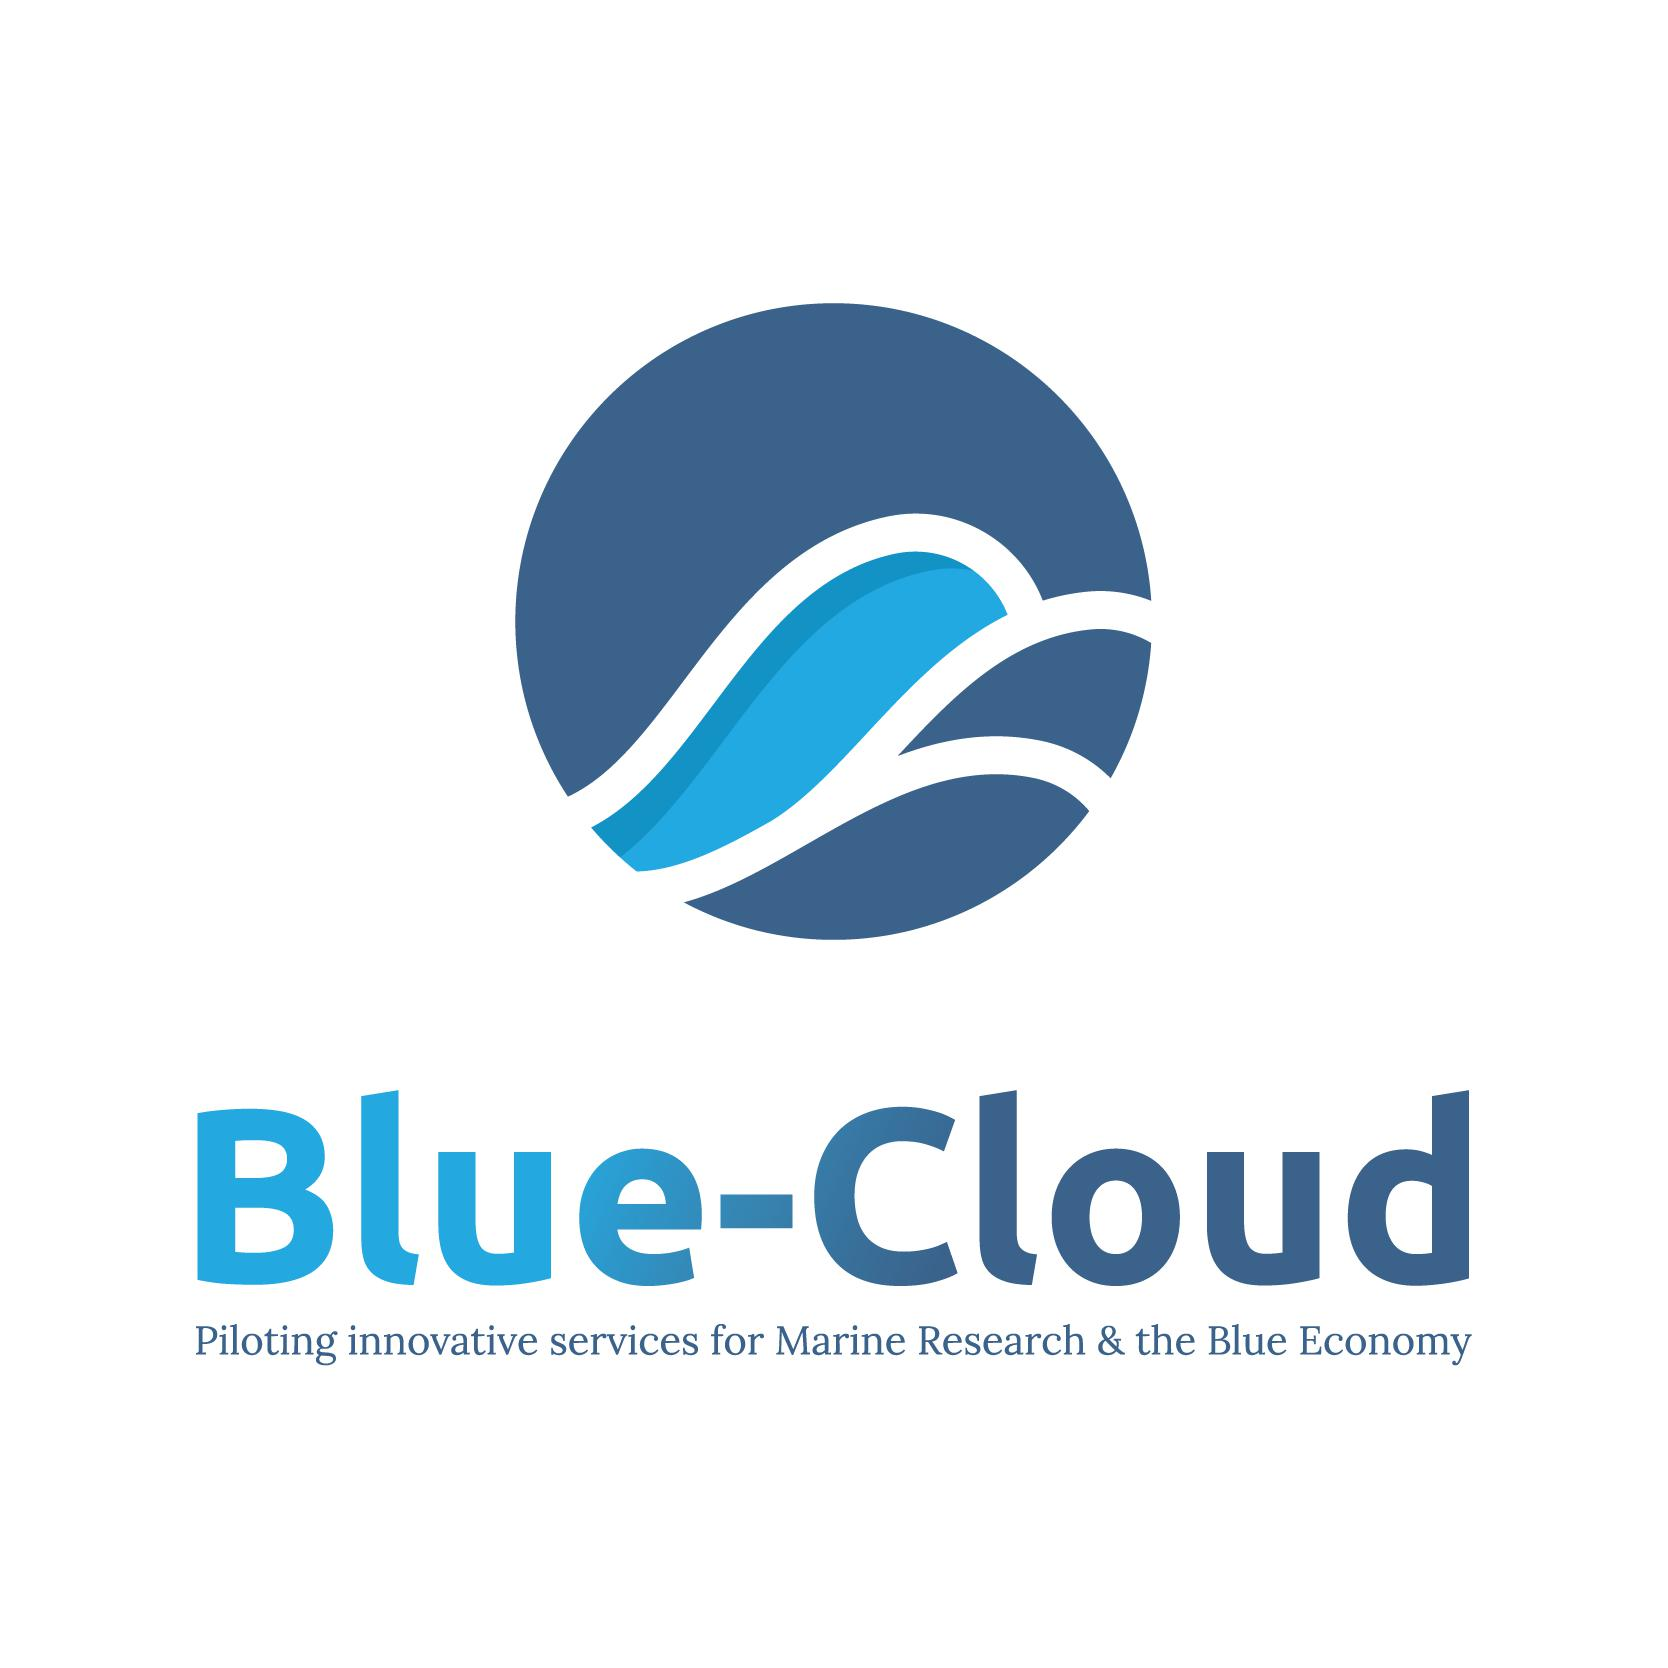 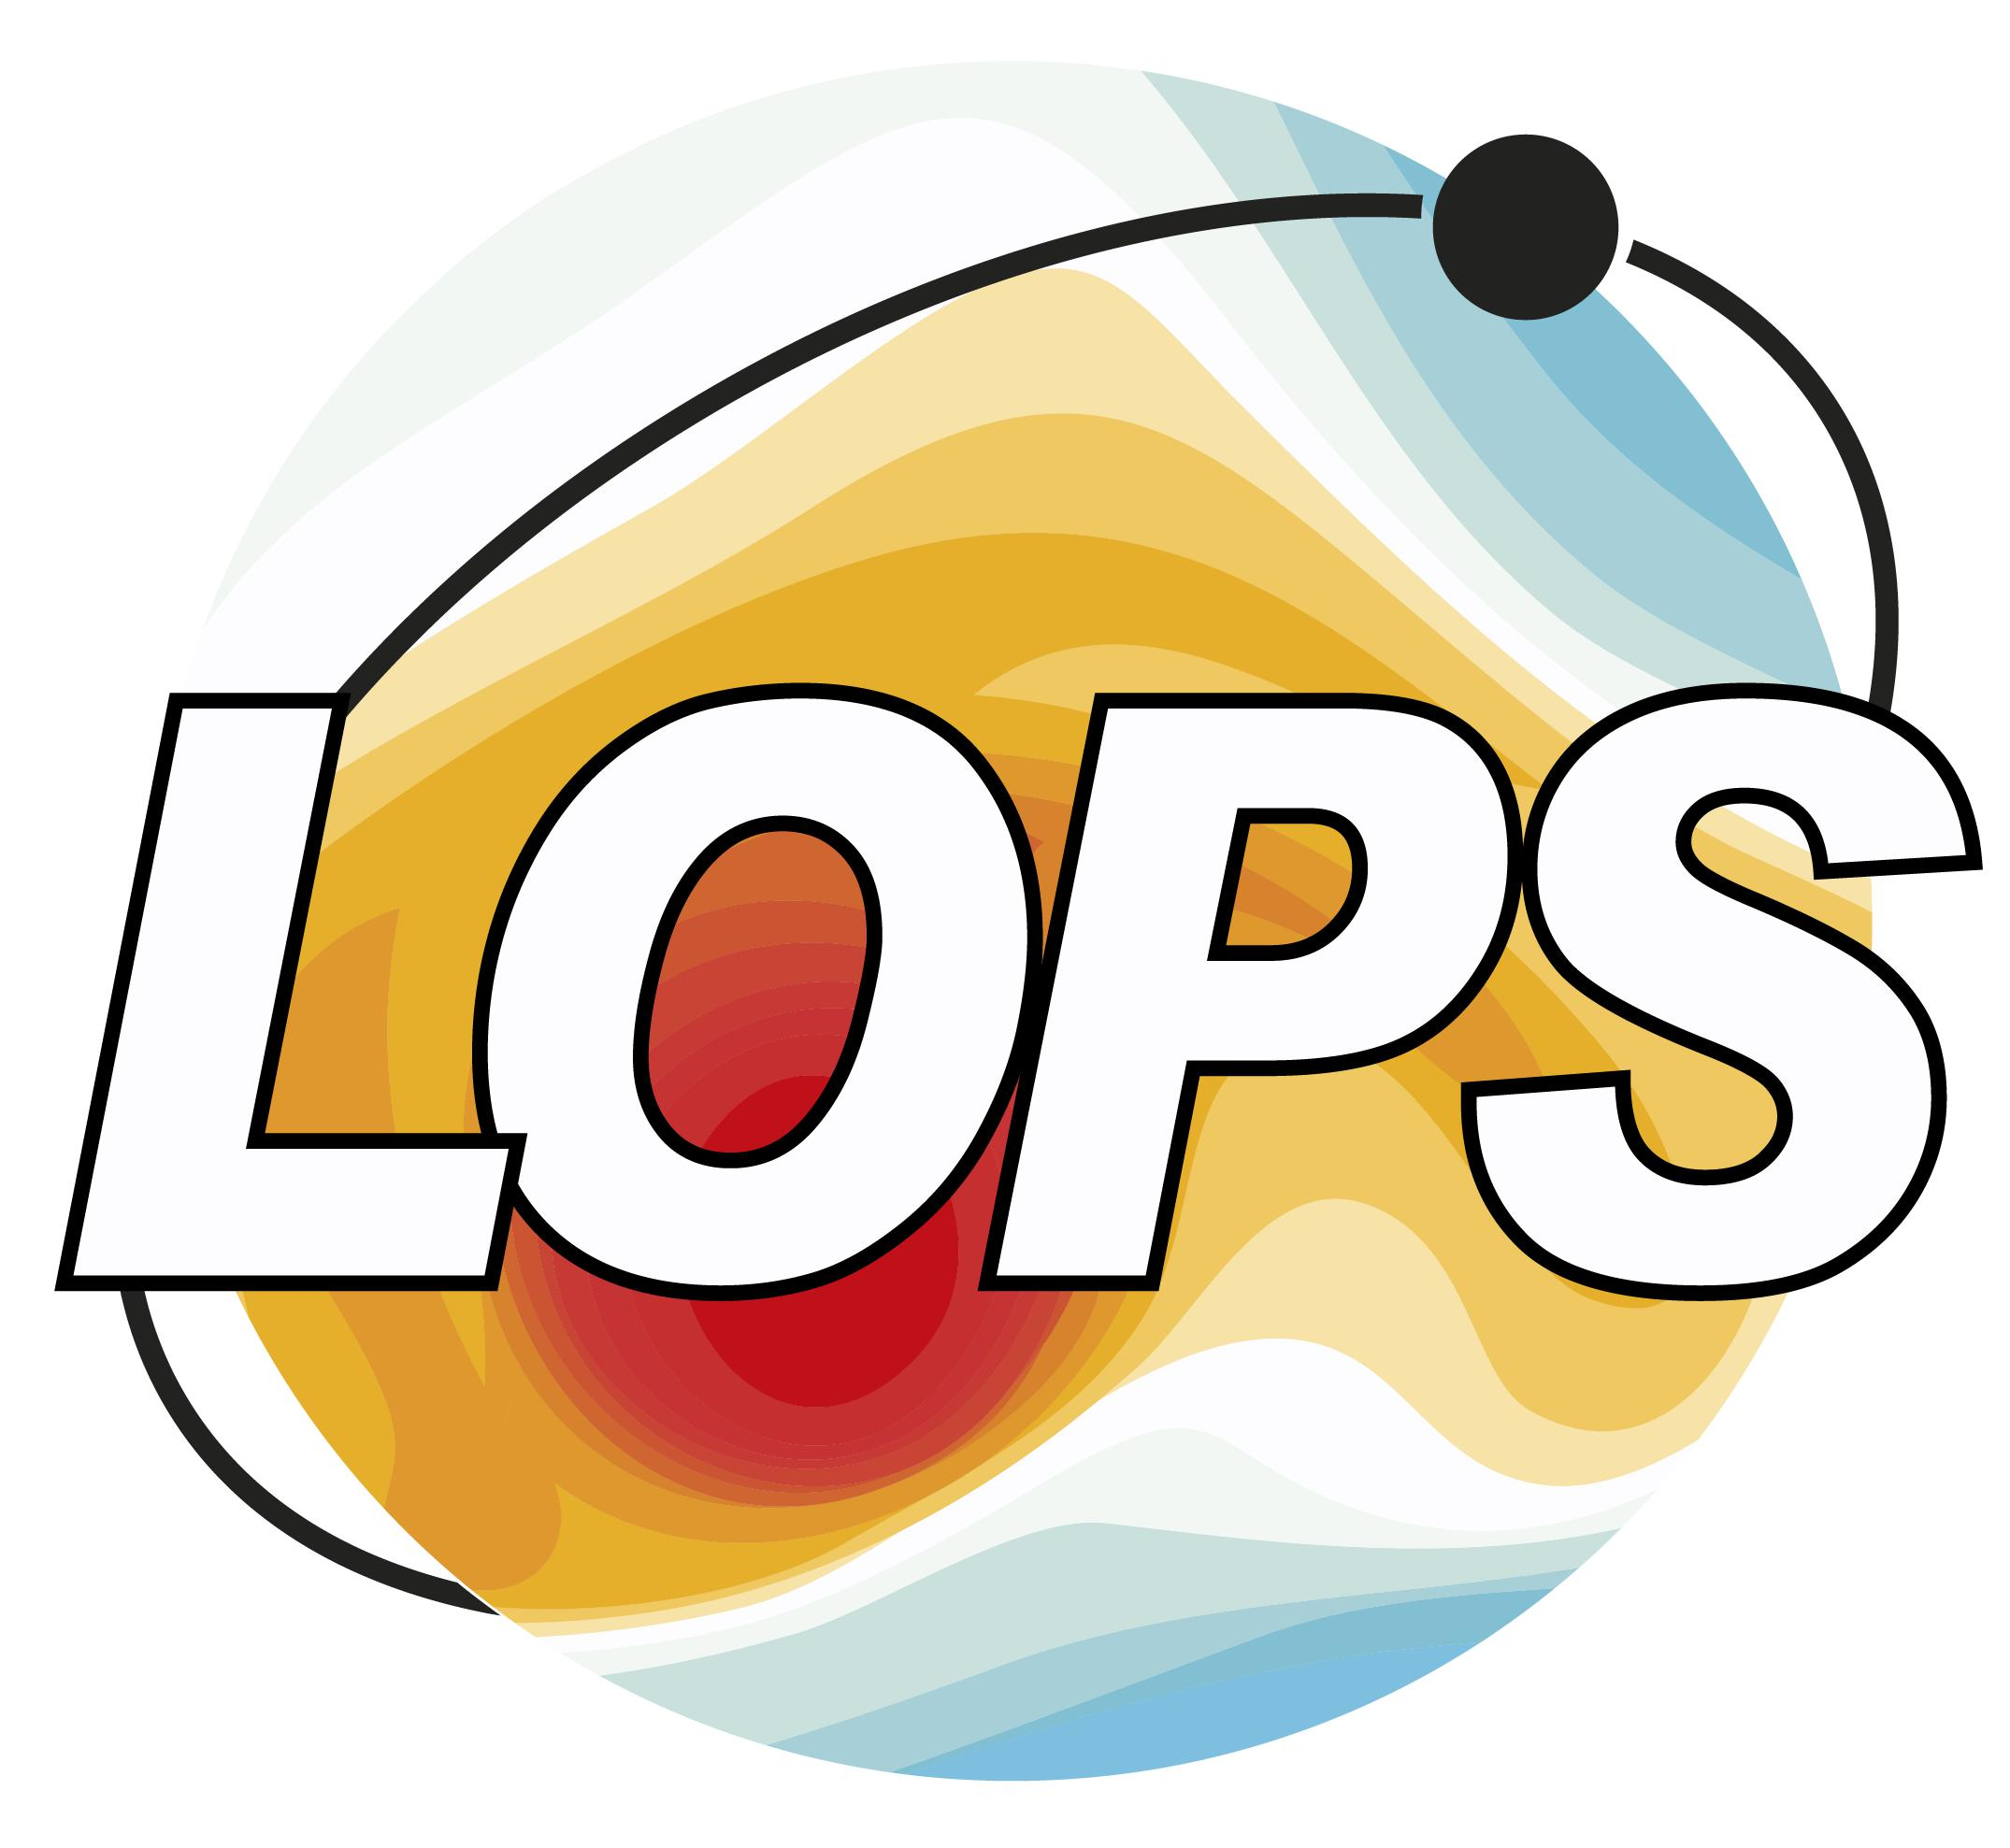
</div>

In [49]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

import concurrent.futures
from tqdm import tqdm

## User input
***

In this section you should provide the __training dataset__ information and the __model__ parameters.

The notebook have been optimazed to use some CMEMS products (see cell below). You can try to use other datasets but you should maybe modify some cells. 

__Training dataset__

Training dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

Data cames from monthly mean fields dataset of *GLOBAL_REANALYSIS_PHY_001_030* product, an eddy-resolving reanalysis with 1/12° horizontal resolution and 50 vertical levels (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030) for getting all infomation about the dataset). As an exemple, we propose to you a selection covering the Mediterranean sea during 2018. 

You should provide your CMEMS __user name__ and __password__ below.

In [50]:
CMEMS_user = 'agarcia6'
CMEMS_password = '1802910672Aa#'

__Model parameters__

In the next cell you should choose the __number of classes__ and provide the name of the variable (__feature__) you want to use in the model and in the dataset.

For the number of classes you can choose a number not very hight, then you will optimaze the number in the plot seccion using th BIC (link) and you can came back here and ude the optimaze number of calsses to train the model again.

In [51]:
# number of classes
K=6

# name of variables (features)
var_name_ds = 'thetao' 
var_name_mdl = 'temperature'

## Load training dataset
***

Training dataset is download from __CMEMS__ servers using a Motu client and saved it as a NetCDF file in *datasets/* folder in your workspace. It will take some time.

If you feel confident you can modify downloading parameters to test other dataset selections than the one we propose to you covering Mediterranean. You can also test other variables, but do not forget to change variables names in the cell above. And be carrefull with memory limits.

In [52]:
import subprocess
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly \
-x -5 -X 35 -y 30 -Y 46 -t "2018-01-01" -T "2018-12-31" -z 0.0 -Z 2500.0 \
-v so -v thetao -o datasets -f global-reanalysis-phy-001-030-monthly_med.nc'
sp = subprocess.call(bashCommand, shell=True)
file_path = 'datasets/global-reanalysis-phy-001-030-monthly_med.nc'

*xarray* library is used to load the training dataset from the NetCDF file

In [7]:
ds = xr.open_dataset(file_path)

#some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'
z_dim = 'depth'

ds

<xarray.Dataset>
Dimensions:    (depth: 41, latitude: 193, longitude: 481, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -1941.893 -2225.078
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 45.916668 46.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -5.0 -4.9166665 -4.8333335 ... 34.916668 35.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Quick plot of the training dataset. Please, choose time and depth slide if needed.

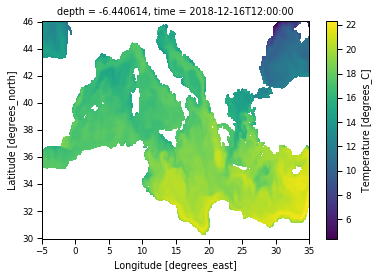

In [8]:
ds[var_name].isel(time=11, depth=5).plot();

## Create and train model
***

In this section the model is created using the number of classes and the feature given as input. Then, the model is trained (__fitted__) with the training dataset and profiles are classified (__predict__) in order to make some usefull plots below

### Create PCM

In [24]:
#fearure choise
z = ds[z_dim][0:40]
pcm_features = {var_name_mdl: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [25]:
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl : var_name_ds}

m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 12.298893

## Development plots
***

Plots in this section will help you to __optimaze__ the model parameters (number of classes) and to take a llok of how model in classifying the profiles. 

#### __1. Scatter plot of features, as seen by the classifier__

__TODO__: Plot only first dimension for each feature

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim=z_dim)

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, kde=True, dim=z_dim)

#### __2. Mask__

When fitting the model, the pyxpcm sorfware __preprocessed__ the data in order to use profiles without NaNs values. THis is donne using a mask that can be plotted below. You can see how is the real dataset that is used for fitting the model after processing. You can chose the time slide to be plotted.

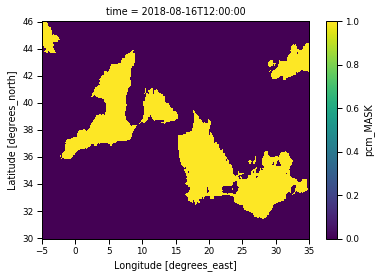

In [32]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=z_dim)
mask.plot()

#### __3. BIC__

The BIC (Bayesian Information Criteria) is the way we use to __optimize the number of classes__ to be used, trying not to overfit or underfit the data. For calculating this index we fit the model to the trining dataset for a range of 0 to 20 number of classes, doing 10 runs each time to calculate the standard devaition. The minimun in the BIC curve give to you the best number of calsses to be used.

For each run we use a sub-dataset of the training dataset as it is very important that profile are not correlated nor spatially or temporally if we want to get a minimun. Spatial and temporal correaltion in the training dataset are user input that should be given below. For our exmple in the mediterranean sea values have been optimaze, but If you want to try another dataset, or even another geographical selection you should know well your dataset in order to provide the good values.

You can also choose the number of runs for aech number of classes and the max number of classes

remapping function 

In [33]:
#function remapping grid using start point and grid extent

def mapping_corr_dist(coor_dist, start_point, grid_extent):

    # angular distance d/earth's radius (km)
    delta = coor_dist/6371
    
    # all in radians (conversion at the end)
    grid_extent = grid_extent*np.pi/180
    start_point = start_point*np.pi/180
    
    ### while loop for lat nord ###
    max_lat = grid_extent[3]
    lat2 = -np.pi/2 
    lat1 = start_point[1]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_lats = [lat1]
    while lat2 < max_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) + np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

        
    ### while loop for lat sud ###
    min_lat = grid_extent[2]
    lat2 = np.pi/2 
    lat1 = start_point[1]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while lat2 > min_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) - np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2
    
    new_lats = np.sort(new_lats)*180/np.pi
    
    ### while loop for lon east ###
    max_lon = grid_extent[1]
    lon2 = -np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = pi/2 donc cos(pi/2)=0 and sin(pi/2)=1
    new_lons = [lon1]
    dlon = np.arctan2(np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 < max_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    ### while loop for lon west ###
    min_lon = grid_extent[0]
    lon2 = np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = -pi/2 donc cos(-pi/2)=0 and sin(-pi/2)=-1
    dlon = np.arctan2(-np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 > min_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    new_lons = np.sort(new_lons)*180/np.pi
    
    return new_lats, new_lons

__User input__

In [45]:
corr_dist = 40
Nrun = 10
NK = 20
#only one time step
dsp = ds.isel(time=9)

Calculation using paralelisation

In [46]:
#start = time.time()

# grid extent
grid_extent = np.array([ds.longitude.values.min(), ds.longitude.values.max(), ds.latitude.values.min(), ds.latitude.values.max()])

class_list = np.arange(0,NK) # this is the list of arguments to iterate over, for instance nb of classes for a PCM

def BIC_cal(X, k):
    """ Function to run on a single argument """
    
    #create model
    m = pcm(K=k+1, features=pcm_features)
    #fit model
    m._classifier.fit(X)
    
    #calculate LOG LIKEHOOD
    llh = m._classifier.score(X)

    # calculate Nb of independant parameters to estimate
    # we suppose m._classifier.covariance_type == 'full'
    _, n_features = m._classifier.means_.shape
    cov_params = m._classifier.n_components * n_features * (n_features + 1) / 2.
    mean_params = n_features * m._classifier.n_components
    Nf = int(cov_params + mean_params + m._classifier.n_components - 1)
    
    #calculate bic
    N_samples = X.shape[0]
    BIC = (-2 * llh * N_samples + Nf * np.log(N_samples))
    #BIC = m._classifier.bic(X)
    
    return BIC, k 

BIC = np.zeros((NK,Nrun)) 
#BIC = []
for run in range(Nrun):
    #print('run=' + str(run))
    
    #random fist point
    latp = np.random.choice(dsp.latitude.values, 1, replace=False)
    lonp = np.random.choice(dsp.longitude.values, 1, replace=False)
    #mapping
    new_lats, new_lons = mapping_corr_dist(coor_dist=corr_dist, start_point=np.concatenate((lonp,latp)), grid_extent=grid_extent)
    ds_ran = dsp.sel(latitude=list(new_lats), longitude=list(new_lons), method='nearest')
    
    # pre-processing
    m = pcm(K=4, features=pcm_features)
    X , sampling_dims = m.preprocessing(ds_ran, features=features_in_ds, dim=z_dim, action='fit')
    
    #BIC computation in parallel
    results = []
    ConcurrentExecutor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    with ConcurrentExecutor as executor:
        future_to_url = {executor.submit(BIC_cal, X, k): k for k in class_list}
        futures = concurrent.futures.as_completed(future_to_url)
        futures = tqdm(futures, total=len(class_list))
        for future in futures:
            traj = None
            try:
                traj = future.result()
            except Exception as e:
                #pass
                raise
            finally:
                results.append(traj)
    results = [r for r in results if r is not None]  # Only keep non-empty results
    results.sort(key=lambda x:x[1])
    BIC[:,run] = np.array([i[0] for i in results])
    
#end = time.time()
#print((end - start)/60)

100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


*PLOT*

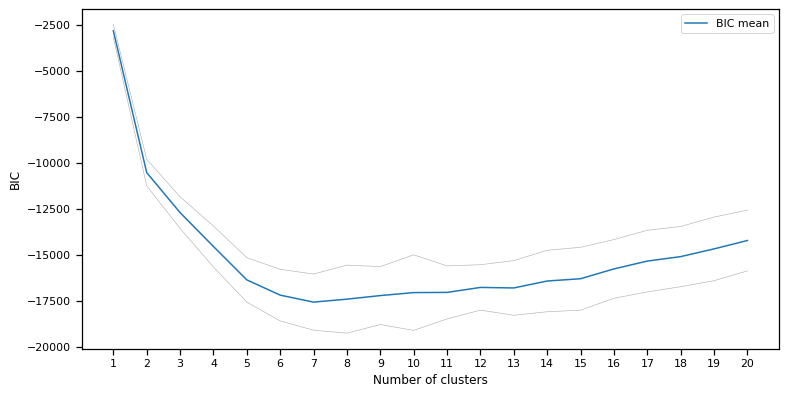

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
normBICstd = np.std(normBICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(NK)+1,BICmean,label='BIC mean')
plt.plot(np.arange(NK)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(NK)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(NK)+1)
plt.legend()

__Number of classes to be used:__

In [48]:
op_classes = np.argmin(BICmean)+1
op_classes

7

If this is not the number of classes you chose in the begging of the notebook, you shoul go back, choose the good number of classes and trin (fit) your model again.

#### __4. Robustness__

THe PCM robustness represent the probability of a profile to belong to a class. It can be usefull to determine the number of classes and the robustness of the model. If a lot os profiles show very low values you should maybe change the number of classes.

In [ ]:
#m.fit(ds, features=features_in_ds, dim=z_dim);
#m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

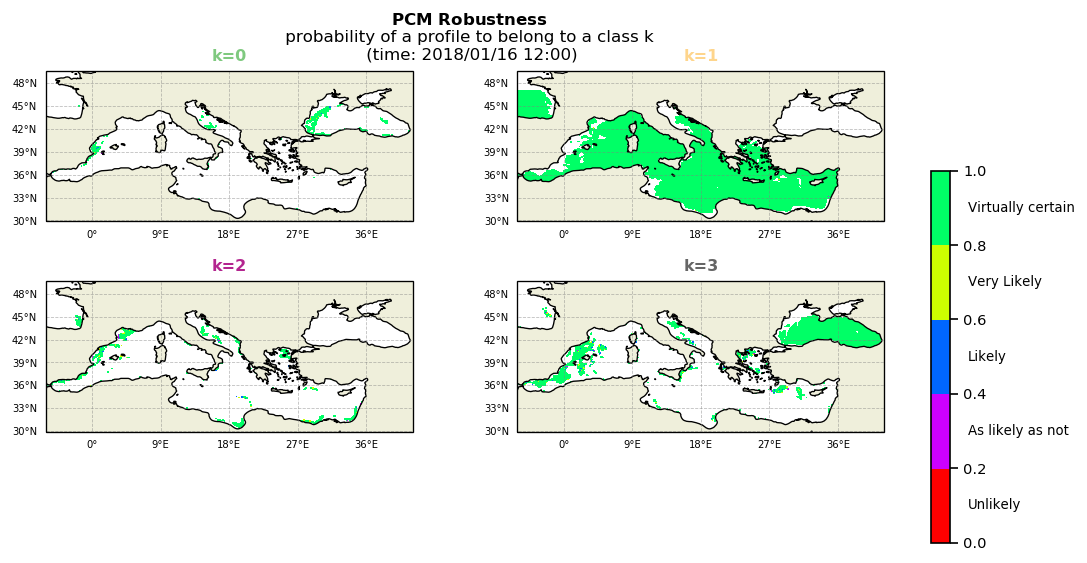

In [24]:
P = Plotter(ds, m)
P.plot_robustness(time_slice="2018-01-01")

## Save fitted model
***

If you feel confortable with you model, you can save it in the *models/* folder and use it in the *predict_PCMlabels_and_plot.IPYNB* notebook to classify (predict) a dataset and plot the results corresponding to __ocean patterns indicator__.

In [ ]:
# save model to development
m.to_netcdf('models/tests_model.nc')